In [1]:
import numpy
import matplotlib.pyplot as plt
import tamaas

from numpy import pi
from IPython.display import display, Latex
from matplotlib.colors import LogNorm

In [2]:
plt.rc('figure', dpi=100)

# Generating Rough Surfaces

*Before you begin: if you've downloaded this notebook, make sure you have the dependencies installed. `python3 -m pip install --user -r requirements.txt` should set you up nicely.*

In this notebook, we'll see how to use Tamaas to generate random, periodic rough surfaces. The algorithms in Tamaas all expect a definition of the Power Spectrum Density (PSD), although the code is very flexible and gives a lot of freedom to the user in this regard. For starters, we'll use two classes shipped with Tamaas that define two different PSD.

The first is the `tamaas.Isopowerlaw` class. It has three wavenumber parameters `q0, q1, q2` and a Hurst exponent. The second is the `tamaas.RegularizedPowerlaw` class, which has only two wavenumber parameters (and the Hurst exponent). Below is a graph showing the two power laws.

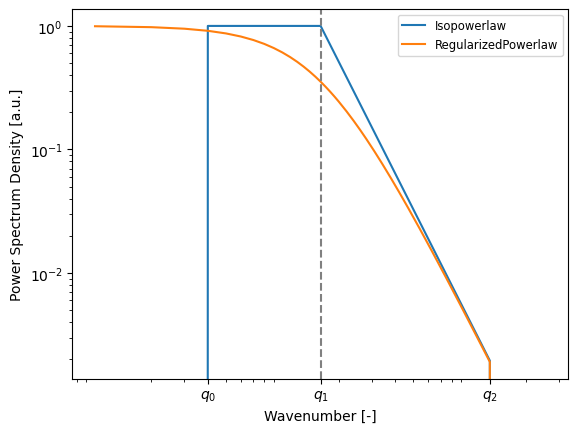

In [3]:
%%capture --no-display
fig, ax = plt.subplots()

q0 = 4
q1 = 16
q2 = 128
H = 0.5

def isopowerlaw(q):
    if q < q0:
        return 0.
    elif q > q2:
        return 0.
    elif q < q1:
        return 1.
    else:
        return (q / q1)**-(2 * H + 2)
    
def regularizedpowerlaw(q):
    if q > q2:
        return 0.
    else:
        return (1 + (q / q1)**2)**-(H + 1)
    
isopowerlaw = numpy.vectorize(isopowerlaw)
regularizedpowerlaw = numpy.vectorize(regularizedpowerlaw)
    
q = numpy.arange(1, 256)

ax.plot(q, isopowerlaw(q), label='Isopowerlaw')
ax.plot(q, regularizedpowerlaw(q), label='RegularizedPowerlaw')
ax.axvline(q1, color='gray', ls='--')

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xticks([q0, q1, q2])
ax.set_xticklabels(['$q_0$', '$q_1$', '$q_2$'])

ax.set_xlabel('Wavenumber [-]')
ax.set_ylabel('Power Spectrum Density [a.u.]')

ax.legend(fontsize='small')
plt.show()

The powerlaw exponent in the above graph is controlled by the Hurst exponent `H`.

## Creating the spectrum objects

Let's create a 2D surface. For that we'll need a `tamaas.Isopowerlaw2D` object and set its parameters.

In [4]:
spectrum = tamaas.Isopowerlaw2D()
spectrum.q0 = q0
spectrum.q1 = q1
spectrum.q2 = q2
spectrum.hurst = H

The `spectrum` object can be queried to know some of the asymptotic properties of surfaces generated with it. For example, we can know in advance the root-mean-square of heights or the root-mean-square of slopes.

In [5]:
rms_heights = spectrum.rmsHeights()
rms_slopes = spectrum.rmsSlopes()

display(Latex(r'$\sqrt{{\langle h^2 \rangle}} \approx {:.0f}$'.format(rms_heights)))
display(Latex(r'$\sqrt{{\langle \nabla h^2 \rangle}} \approx {:.0f}$'.format(rms_slopes)))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## Creating the surface generator

To generate the rough surface, we need a surface generator object. Tamaas implements two methods with two separate classes: `tamaas.SurfaceGeneratorFilter` and `tamaas.SurfaceGeneratorRandomPhase`. The former generates a surface by the product of the Fourier transform of gaussian noise and the desired surface spectrum, while the latter generates uniform random phases without altering the power spectrum. This leads to a lower variance of statistical quantities in the surfaces generated compared to `tamaas.SurfaceGeneratorFilter`, but depending on the application adding noise to the power spectrum might be a desired effect. For simplicity, let's use the `tamaas.SurfaceGeneratorRandomPhase` class.

In [6]:
N = 512  # Number of points (should be at least 2 * q2)

generator = tamaas.SurfaceGeneratorRandomPhase2D([N, N])
generator.spectrum = spectrum
generator.random_seed = 42

We can easily generate a surface for the seed we specified.

In [7]:
surface = generator.buildSurface()

**Important**: the object `surface` is a *reference* to an array internal to `generator`. That means that if you change the `random_seed` or the `spectrum` and call `buildSurface()` again, the object `surface` will automatically change.

Let's plot our new surface.

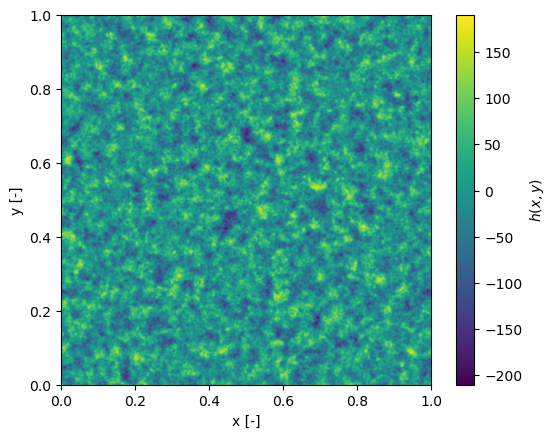

In [8]:
fig, ax = plt.subplots()

image = ax.imshow(surface, extent=(0, 1, 0, 1), origin='lower')
fig.colorbar(image).set_label('$h(x, y)$')

ax.set_xlabel('x [-]')
ax.set_ylabel('y [-]')
plt.show()

## Statistical properties

We can use the class `tamaas.Statistics2D` to compute stats on our surface. For example, we can check that the values of the RMS of heights and slopes are correct (i.e. close to the theoretical value from the `spectrum`).

In [9]:
rms_heights = tamaas.Statistics2D.computeRMSHeights(surface)
rms_slopes = tamaas.Statistics2D.computeSpectralRMSSlope(surface)

display(Latex(r'$\sqrt{{\langle h^2 \rangle}} \approx {:.0f}$'.format(rms_heights)))
display(Latex(r'$\sqrt{{\langle \nabla h^2 \rangle}} \approx {:.0f}$'.format(rms_slopes)))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Although some of these statistics can be computed with Numpy/Scipy, `tamaas.Statistics2D` is the prefered way to do it because it handles cases when the program is run in an MPI environment. It can also be used to compute more advanced functions, such as the power density spectrum or the autocorrelation.

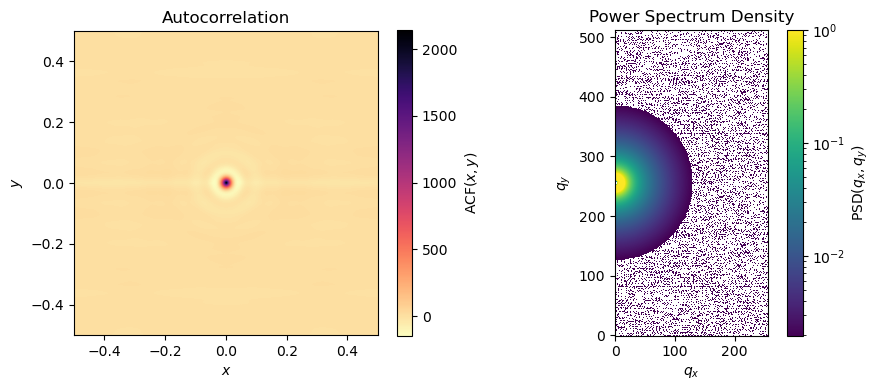

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4))

psd = tamaas.Statistics2D.computePowerSpectrum(surface)
acf = tamaas.Statistics2D.computeAutocorrelation(surface)

# Plot autocorrelation (we use fftshift to rearrange data)
image = axs[0].imshow(numpy.fft.fftshift(acf), extent=(-0.5, 0.5, -0.5, 0.5),
                      origin='lower', cmap='magma_r')
fig.colorbar(image, ax=axs[0]).set_label('ACF$(x, y)$')
axs[0].set_title("Autocorrelation")
axs[0].set_xlabel('$x$')
axs[0].set_ylabel('$y$')

# We use a logarithmic color scale
norm = LogNorm(vmin=(q2 / q1)**-(2 * H + 2), vmax=1)
# Shift only along one axis due to r2c transform
image = axs[1].imshow(numpy.fft.fftshift(psd, axes=0).real,
                      origin='lower', norm=norm)
fig.colorbar(image, ax=axs[1]).set_label('PSD$(q_x, q_y)$')
axs[1].set_title('Power Spectrum Density')
axs[1].set_xlabel('$q_x$')
axs[1].set_ylabel('$q_y$')

fig.tight_layout()
plt.show()

We can look at our isotropic powerlaw in 1D by radially averaging the computed PSD with the function `tamaas.utils.radial_average`.

In [11]:
%%capture
from tamaas.utils import radial_average

# Center PSD and select real values
psd_ = numpy.fft.fftshift(psd, axes=0).real

# Construct q-coordinate space
qx = numpy.arange(-psd_.shape[0] // 2, psd_.shape[0] // 2)
qy = numpy.arange(psd_.shape[1])

# Construct polar coordinates (must be within the qx x qy domain)
r = numpy.linspace(0, N//2 - 1, N * 2)
theta = numpy.linspace(0, numpy.pi, 100)

# Do the radial average with nearest point interpolation
psd_iso = radial_average(qx, qy, psd_, r, theta, method='nearest')

0.000803859212769702


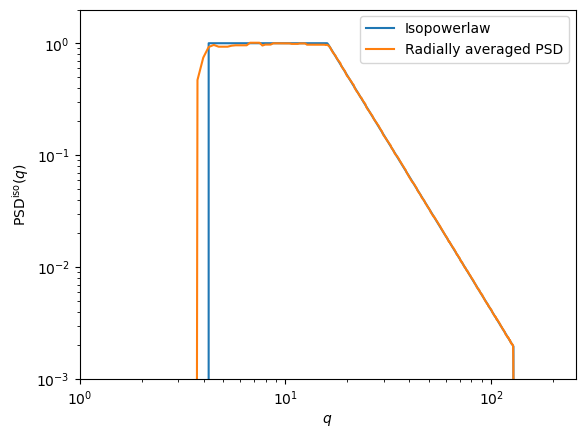

In [12]:
fig, ax = plt.subplots()

# Plot theoretical PSD
ax.loglog(r, isopowerlaw(r), label='Isopowerlaw')

# Plot averaged PSD
ax.loglog(r, psd_iso, label='Radially averaged PSD')

ax.set_xlim(1, N // 2)
ax.set_ylim(1e-3, 2)

ax.set_xlabel("$q$")
ax.set_ylabel('PSD$^\\mathrm{iso}(q)$')

ax.legend()

print(numpy.mean((isopowerlaw(r)-psd_iso)**2))

plt.show()

## Normalizing a surface

Sometimes a specific value of the RMS of heights or slopes is derired for a surface. In Tamaas, these values can be enforced after the surface has been generated by normalizing with either the theoretical value (the preferred way when possible, because it is unbiased) or a value computed with `tamaas.Statistics2D`.

In [13]:
target_rms_heights = 0.1

# Normalizing the surface with theoretical RMS heights
surface *= target_rms_heights / spectrum.rmsHeights()

display(Latex(r'New $\sqrt{{\langle h^2 \rangle}} = {:.2f}$'.format(tamaas.Statistics2D.computeRMSHeights(surface))))

<IPython.core.display.Latex object>

## Custom spectrum

Custom spectra objects can be created directly in Python by declaring a subclass to `tamaas.Filter2D`. This subclass will be queried for the Fourier coefficents of the power spectrum. For example, below is a class that computes these coefficents from a specified autocorrelation function.

In [14]:
class AutocorrelationFilter(tamaas.Filter2D):
    def __init__(self, autocorrelation):
        tamaas.Filter2D.__init__(self)
        self.autocorrelation = autocorrelation.copy()

    def computeFilter(self, filter_coefficients):
        shifted_ac = numpy.fft.ifftshift(self.autocorrelation)
        
        # Fill in the PSD coefficients
        filter_coefficients[...] = numpy.sqrt(numpy.fft.rfft2(shifted_ac))
        # Normalize
        filter_coefficients[...] *= 1 / numpy.sqrt(self.autocorrelation.size)

Let's create a surface with a gaussian autocorrelation.

In [15]:
sigma = 1e-4

x = numpy.linspace(-0.5, 0.5, N)
y = numpy.linspace(-0.5, 0.5, N)

xx, yy = numpy.meshgrid(x, y, indexing='ij')
acf = numpy.exp(- (xx**2 + yy**2) / (2 * sigma)) / (sigma * numpy.sqrt(2 * pi))

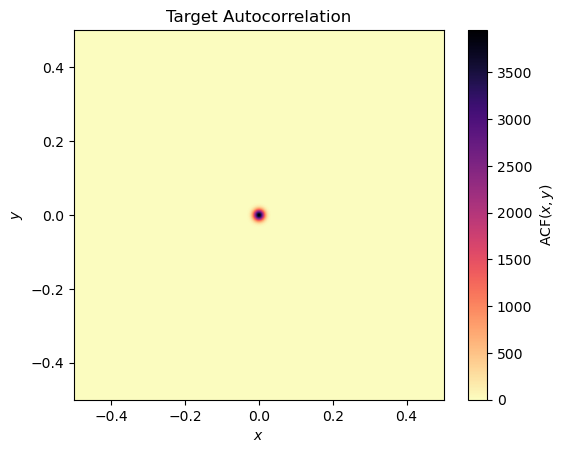

In [16]:
fig, ax = plt.subplots()

image = ax.imshow(acf, extent=(-0.5, 0.5, -0.5, 0.5), origin='lower', cmap='magma_r')
fig.colorbar(image).set_label("ACF($x, y$)")

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_title("Target Autocorrelation")

plt.show()

In [17]:
spectrum = AutocorrelationFilter(acf)
generator.spectrum = spectrum
surface = generator.buildSurface()

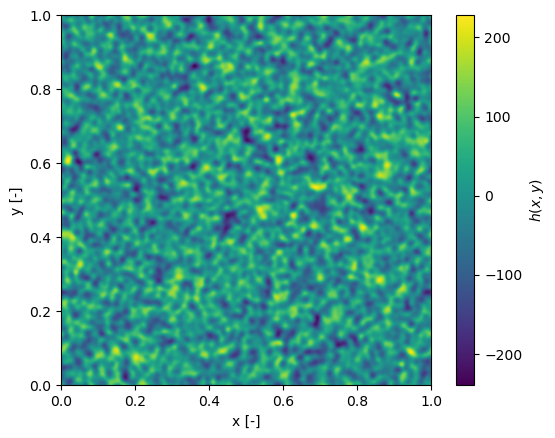

In [18]:
fig, ax = plt.subplots()

image = ax.imshow(surface, extent=(0, 1, 0, 1), origin='lower')
fig.colorbar(image).set_label('$h(x, y)$')

ax.set_xlabel('x [-]')
ax.set_ylabel('y [-]')
plt.show()

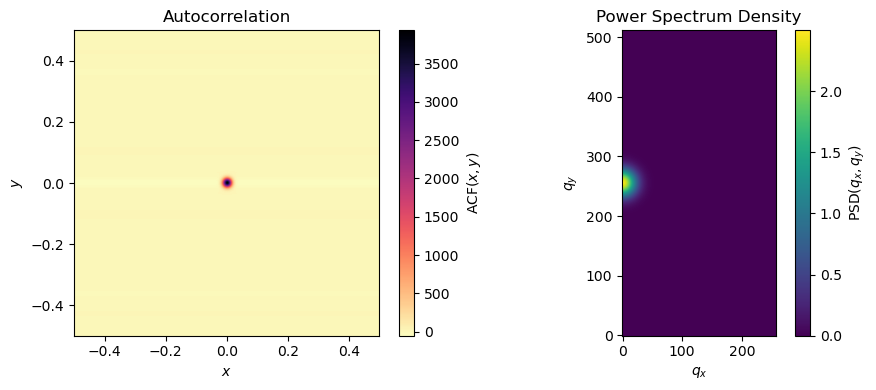

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4))

psd = tamaas.Statistics2D.computePowerSpectrum(surface)
acf = tamaas.Statistics2D.computeAutocorrelation(surface)

image = axs[0].imshow(numpy.fft.fftshift(acf), extent=(-0.5, 0.5, -0.5, 0.5),
                      origin='lower', cmap='magma_r')
fig.colorbar(image, ax=axs[0]).set_label('ACF$(x, y)$')
axs[0].set_title("Autocorrelation")
axs[0].set_xlabel('$x$')
axs[0].set_ylabel('$y$')

image = axs[1].imshow(numpy.fft.fftshift(psd, axes=0).real,
                      origin='lower')
fig.colorbar(image, ax=axs[1]).set_label('PSD$(q_x, q_y)$')
axs[1].set_title('Power Spectrum Density')
axs[1].set_xlabel('$q_x$')
axs[1].set_ylabel('$q_y$')

fig.tight_layout()
plt.show()

We recover our input autocorrelation!